The goal is to try and calculate the coupling Qs for a double resonator scheme as is implemented for the TLS Screener Chips. I'll start with a simpler one resonator case for which the resonance frequencies are easily obtained from the zeros of the impedance. 

In [1]:
import numpy as np
from math import pi
import cmath
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt

In [2]:
nH = 1e-9
pF = 1e-12
MHz = 1e6

I'll pick a range of values for coupling capacitance

In [3]:
L = 3*nH
C = 40*pF
Z0 = 50 #Ohms
N = 5
Cc = np.arange(1, N)*0.1*pF
Qi = 1e5
f = np.linspace(400, 600, 100000)*MHz
w = 2*pi*f
R = 5e5 #Ohms

In [4]:
Ct = C + Cc
w0 = 1/(L*Ct)**0.5
Qis = w0*R*C
frs = (w0*(1-1/4/Qis**2)**0.5)/2/pi/MHz
# print (Qi)
# print(frs)
Qcs = (2*C)/(Z0*2*pi*frs*MHz*Cc**2)
Qrs = 1/(1/Qcs + 1/Qis)

Fitting functions for extracting out the resonance parameters

In [5]:
def I(theta, f):
    f0, Qcd, Qrd = theta
    x = (f-f0)/f0
    return 1 - (Qcd*Qrd)/(Qrd**2 + 4*x**2)

def Q(theta, f):
    f0, Qcd, Qrd = theta
    x = (f-f0)/f0
    return (2*x*Qcd)/(Qrd**2 + 4*x**2)

def S21_fit(theta, f):
    f0, Qcd, Qrd = theta
    x = (f-f0)/f0
    return 1 - Qcd/(Qrd + 1j*2*x)
        
def chisq(theta, f, y):
    return 0.5*np.sum((y.real - I(theta, f))**2) + 0.5*np.sum((y.imag - Q(theta, f))**2)

def get_Qparams(f, S21):
    Qi = 5e4
    x0 = [f[np.argmin(S21.real)], 1/Qi, 2/Qi] 
    result = opt.minimize(chisq, x0, args=(f, S21), method='Nelder-Mead')
    f0, Qcd, Qrd = result["x"]
    return f0, 1/Qcd, 1/Qrd

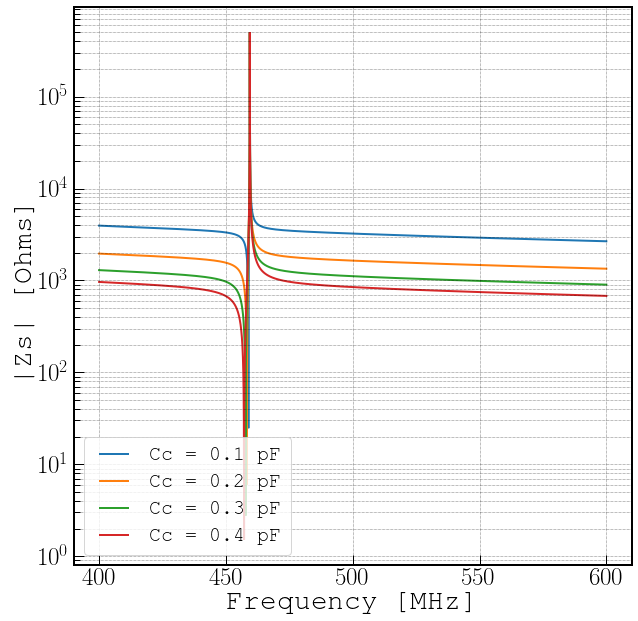

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(N-1):
    Zr = (1j*w*R*L)/(1j*w*L + R*(1 - w**2*L*C)) 
    Zs = Zr + 1/(1j*w*Cc[i])
    S21 = (2*Zs)/(2*Zs + Z0)
    ax.semilogy(f/MHz, np.abs(Zs), label="Cc = {0:3.1f} pF".format(Cc[i]/pF))
ymin, ymax = ax.get_ylim()
# for i in range(N-1):
#     ax.vlines(frs[i], ymin, ymax, 'k')
ax.legend(loc='lower left')
ax.grid(which='both')
# ax.set_ylim([-25000, 25000])
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('|Zs| [Ohms]');

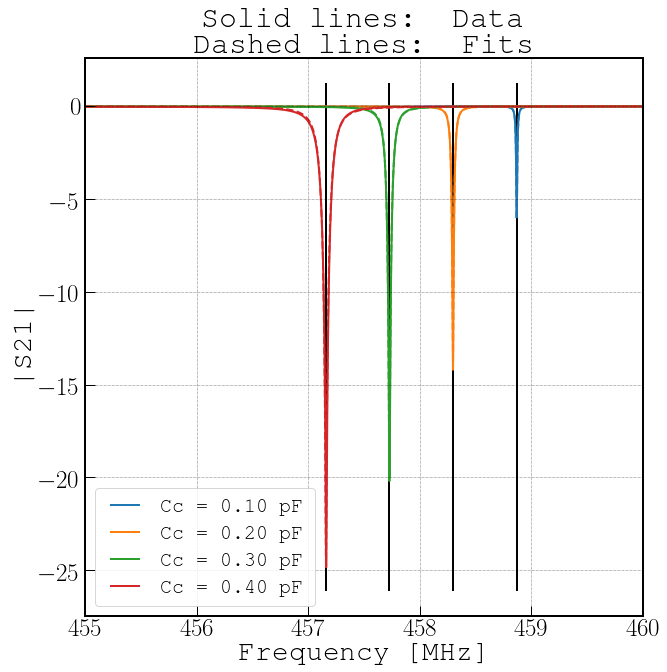

In [13]:
Qr_fitted = np.zeros(N-1)
Qi_fitted = np.zeros(N-1)
Qc_fitted = np.zeros(N-1)
f0_fitted = np.zeros(N-1)
fig, ax = plt.subplots(figsize=(10,10))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i in range(N-1):
    Zr = (1j*w*R*L)/(1j*w*L + R*(1 - w**2*L*C)) 
    Zs = Zr + 1/(1j*w*Cc[i])
    S21 = (2*Zs)/(2*Zs + Z0)
    f0, Qc, Qr = get_Qparams(f, S21)
    Qi = 1/(1/Qr - 1/Qc)
#     print (frs[i], f0/MHz)
#     print (Qr, Qc, Qi)
    f0_fitted[i] = f0
    Qr_fitted[i] = Qr
    Qi_fitted[i] = Qi
    Qc_fitted[i] = Qc
    S21_fitted = S21_fit([f0, 1/Qc, 1/Qr], f)
    ax.plot(f/MHz, 20*np.log10(np.abs(S21)), color=colors[i], ls='solid', label="Cc = {0:1.2f} pF".format(Cc[i]/pF))
    ax.plot(f/MHz, 20*np.log10(np.abs(S21_fitted)), color=colors[i], ls='dashed')
    ax.set_title('Solid lines: Data\nDashed lines: Fits')
    
ax.set_xlim(455, 460)
f0_fitted = np.array(f0_fitted)
ymin, ymax = ax.get_ylim()
for i in range(N-1):
    ax.vlines(frs[i], ymin, ymax, 'k')
ax.legend(loc='lower left')
ax.grid(which='both')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('|S21|');

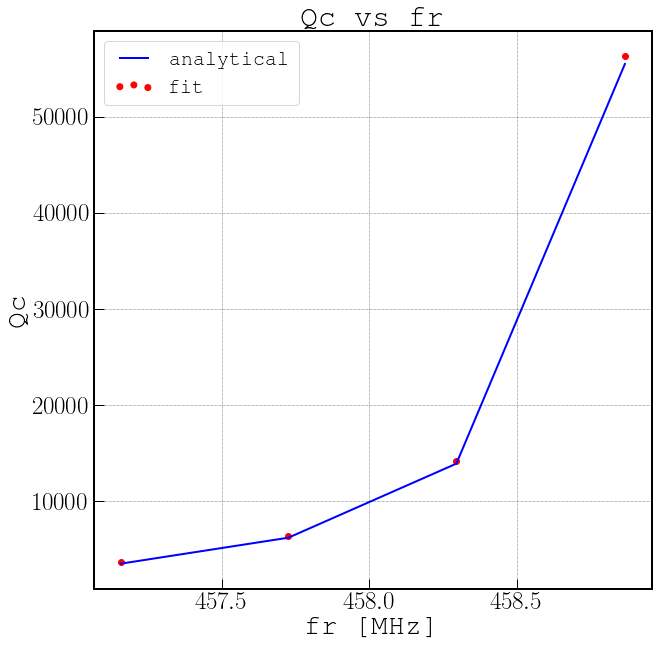

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
# ax.plot(f0_fitted/MHz, 1./Qr_fitted, label='1/Qrs', c=colors[3], ls='-.')
# ax.plot(f0_fitted/MHz, Qc_fitted, label='fit', c=colors[3], ls='--')
ax.scatter(f0_fitted/MHz, Qc_fitted,  c='r', label='fit')
ax.plot(f0_fitted/MHz, Qcs, label='analytical', c='b', ls='-')
# ax.plot(f0_fitted/MHz, 1./Qi_fitted, label='1/Qis', c=colors[1], ls='-.')
ax.grid(which='both')
ax.legend(loc='upper left')
ax.axis('tight')
ax.set_ylabel(r'Qc')
ax.set_xlabel(r'fr [MHz]')
ax.set_title('Qc vs fr');

Alternatively, we could look at the total impedance through the line including the terminating 50 Ohm resistances at the source and load. 

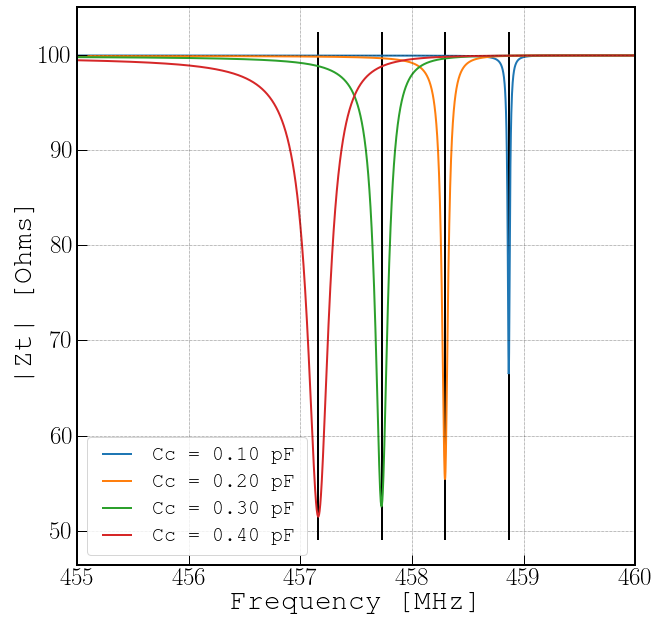

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(N-1):
    Zr = (1j*w*R*L)/(1j*w*L + R*(1 - w**2*L*C)) 
    Zs = Zr + 1/(1j*w*Cc[i])
    Zt = Z0 * (2*Zs + Z0)/(Zs + Z0)
    ax.plot(f/MHz, np.abs(Zt), label="Cc = {0:1.2f} pF".format(Cc[i]/pF))
ax.set_xlim(455, 460)
ymin, ymax = ax.get_ylim()
for i in range(N-1):
    ax.vlines(frs[i], ymin, ymax, 'k')
ax.legend(loc='lower left')
ax.grid(which='both')
# ax.set_ylim([50, 200])
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('|Zt| [Ohms]');

Now let's consider the double resonator case

In [17]:
Lm = 18*nH
we = 1/(L*C)**0.5
Qe = we*R*Ct
Lp = L*(Lm/2)/(L + Lm/2)
wo = 1/(Lp*C)**0.5
Qo = wo*R*Ct
fm = we*(1-L/(4*R**2*C))**0.5/2/pi/MHz
fp = wo*(1-Lp/(4*R**2*C))**0.5/2/pi/MHz
# frs_even = (we)/2/pi/MHz
# frs_odd = (wo)/2/pi/MHz
print (fm, fp)

459.4407461675977 530.5164769580638


In [18]:
w_even = 1/(L*Ct)**0.5
frs_even = w_even*(1-1/4/Qe**2)**0.5/2/pi/MHz
w_odd = 1/(Lp*Ct)**0.5
frs_odd = w_odd*(1-1/4/Qo**2)**0.5/2/pi/MHz
print (frs_even)
print (frs_odd)

[458.86751981 458.29643369 457.72747452 457.16062913]
[529.85457218 529.19513872 528.53816127 527.88362459]


In the analytical case for the double resonator case, the zeros of the impedance are given by the roots of a quartic
polynomial. I numerically solve the equation here to obtain the resonance frequencies.

In [19]:
fr_evens = []
fr_odds = []
for i in range(N-1):
    # Discriminant of a quartic polynomial
    a = C*(C + Cc[i])*L**2*Lm*R**2
    b = (2*C + Cc[i])*L**2*Lm*R
    c = L*(L*Lm + (2*C + Cc[i])*(L + Lm)*R**2)
    d = 2*L*(L + Lm)*R
    e = (2*L + Lm)*R**2
    x1,x2,x3,x4 = np.roots([a,b,c,d,e])
    fr_odds.append(np.abs(np.imag(x1))/2/pi/MHz)
    fr_evens.append(np.abs(np.imag(x3))/2/pi/MHz)
print (fr_evens)
print (fr_odds)

[459.15279119200176, 458.863239736012, 458.5721108980926, 458.2794241530078]
[530.1868673573293, 529.8611619963533, 529.5393274455104, 529.2213300231376]


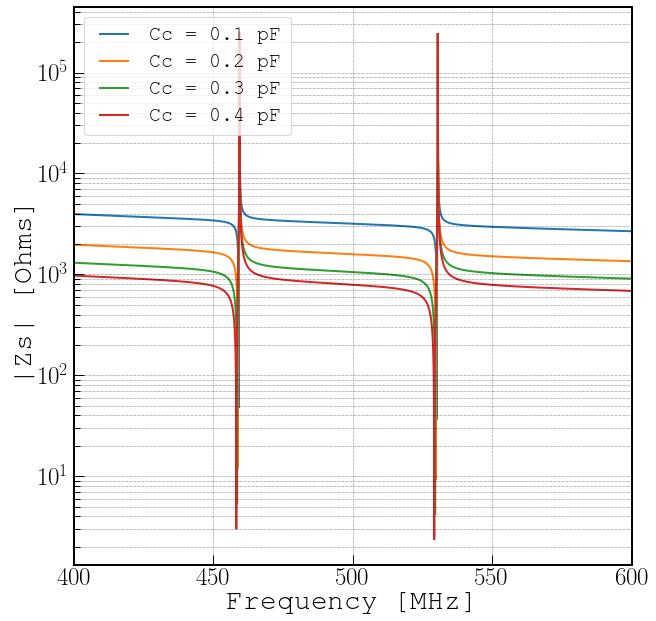

In [22]:
f = np.linspace(400, 600, 100000)*MHz
w = 2*pi*f
fig, ax = plt.subplots(figsize=(10,10))
for i in range(N-1):
    Zr = (1j*w*R*L)/(1j*w*L + R*(1 - w**2*L*C)) 
    Zs = Zr * (Zr + 1j*w*Lm)/(2*Zr + 1j*w*Lm)  + 1/(1j*w*Cc[i])
    S21 = (2*Zs)/(2*Zs + Z0)
    ax.semilogy(f/MHz, np.abs(Zs), label="Cc = {0:3.1f} pF".format(Cc[i]/pF))
ax.set_xlim(400, 600)
ymin, ymax = ax.get_ylim()
# for i in range(N-1):
#     ax.vlines(fr_evens[i], ymin, ymax, 'k')
#     ax.vlines(fr_odds[i], ymin, ymax, 'k')
# ax.vlines(fm, ymin, ymax, 'k', linestyles='dashed')
# ax.vlines(fp, ymin, ymax, 'k', linestyles='dashed')

ax.legend(loc='upper left')
ax.grid(which='both')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('|Zs| [Ohms]');

In [23]:
Qc_lower = np.zeros(N-1)
Qc_upper = np.zeros(N-1)
Qi_lower = np.zeros(N-1)
Qi_upper = np.zeros(N-1)
Qr_lower = np.zeros(N-1)
Qr_upper = np.zeros(N-1)
f0_lower = np.zeros(N-1)
f0_upper = np.zeros(N-1)

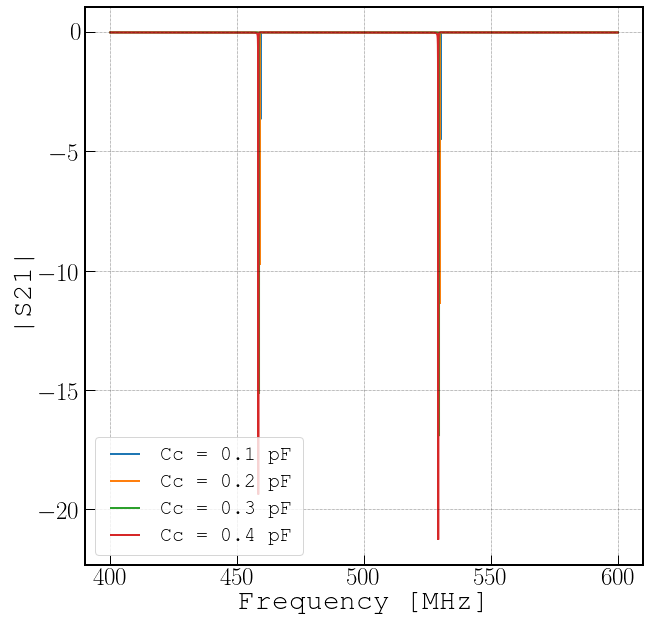

In [24]:
T = len(f)
fig, ax = plt.subplots(figsize=(10,10))
for i in range(N-1):
    Zr = (1j*w*R*L)/(1j*w*L + R*(1 - w**2*L*C)) 
    Zs = Zr * (Zr + 1j*w*Lm)/(2*Zr + 1j*w*Lm)  + 1/(1j*w*Cc[i])
 
    S21 = (2*Zs)/(2*Zs + Z0)
    ax.plot(f/MHz, 20*np.log10(np.abs(S21)), label="Cc = {0:3.1f} pF".format(Cc[i]/pF))
    f0_l, Qc_l, Qr_l = get_Qparams(f[:T//2], S21[:T//2])
    f0_u, Qc_u, Qr_u = get_Qparams(f[T//2:], S21[T//2:])
    Qi_l = 1/(1/Qr_l - 1/Qc_l)
    Qi_u = 1/(1/Qr_u - 1/Qc_u)
    f0_lower[i] = f0_l
    f0_upper[i] = f0_u
    Qc_lower[i] = Qc_l
    Qc_upper[i] = Qc_u
    Qi_lower[i] = Qi_l
    Qi_upper[i] = Qi_u
    Qr_lower[i] = Qr_l
    Qr_upper[i] = Qr_u
#     ax.plot(f/MHz, 20*np.log10(np.abs(S21_est)), ls='dashed', label="Cc = {0:3.1f} pF".format(Cc[i]/pF))
ymin, ymax = ax.get_ylim()
# for i in range(N-1):
#     ax.vlines(fr_evens[i], ymin, ymax, 'k')
#     ax.vlines(fr_odds[i], ymin, ymax, 'k')
ax.legend(loc='lower left')
ax.grid(which='both')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('|S21|');

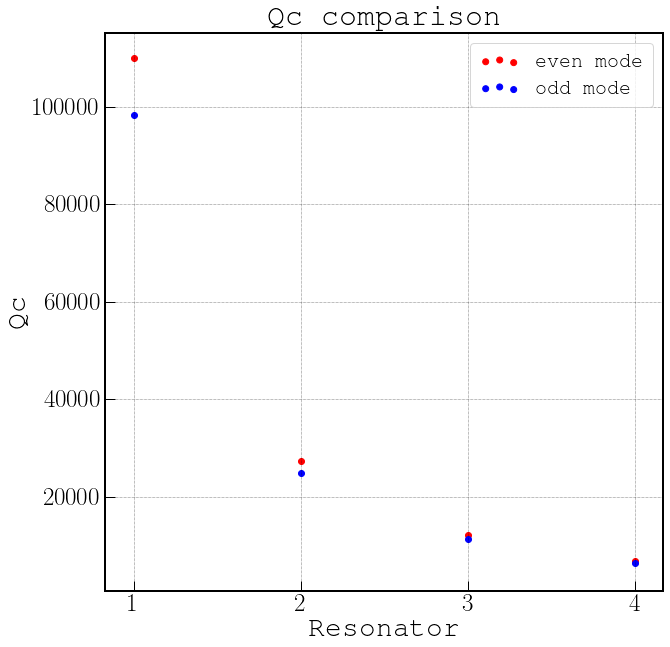

In [25]:
index = np.arange(N-1) + 1
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(index, Qc_lower, label='even mode', c='r')
ax.scatter(index, Qc_upper, label='odd mode', c='b')
ax.set_xticks(index)
ax.grid(which='both')
ax.legend(loc='upper right')
ax.axis('tight')
ax.set_ylabel(r'Qc')
ax.set_xlabel(r'Resonator')
ax.set_title('Qc comparison');

In [30]:
print (Qc_lower)
print (Qc_upper)
print (Qc_lower/Qc_upper)
# print (frs_odd/frs_even)

[109997.80185923  27355.27574974  12091.49552735   6765.27293626]
[98431.33910606 24945.88518843 11270.10080492  6449.2645058 ]
[1.11750793 1.09658469 1.07288264 1.04899914]


In [33]:
print (f0_lower/MHz)
print (f0_upper/MHz)

[459.15271872 458.86300346 458.57152629 458.27821146]
[530.18677985 529.86085823 529.53856093 529.21974892]
